In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
class KMeansClustering():
    def __init__(self, k = 3, tolerance = 0.0001, max_iterations = 500):
        self.k = k
        self.tolerance = tolerance
        self.max_iterations = max_iterations

    def fit(self, data):

        self.centroids = {}
        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iterations):
            self.classes = {}
            for i in range(self.k):
                self.classes[i] = []

            for features in data:
                distances = [np.linalg.norm(features - self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classes[classification].append(features)

            previous = dict(self.centroids)

            for classification in self.classes:
                self.centroids[classification] = np.average(self.classes[classification], axis = 0)

            isOptimal = True

            for centroid in self.centroids:

                original_centroid = previous[centroid]
                curr = self.centroids[centroid]

                if np.sum((curr - original_centroid)/original_centroid * 100.0) > self.tolerance:
                    isOptimal = False

            if isOptimal:
                break

    def pred(self, data):
        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

In [3]:
df = pd.read_csv('mnist_784.csv', header=0)
df = df[1:701]
Y = df['class']
X = df.drop(['class'], axis=1)

X = MinMaxScaler().fit_transform(X=X)

pca = PCA(n_components=2)

principal = pca.fit_transform(X)
principal = list(map(list, zip(*principal)))
principal_df = pd.DataFrame(zip(*principal, Y))

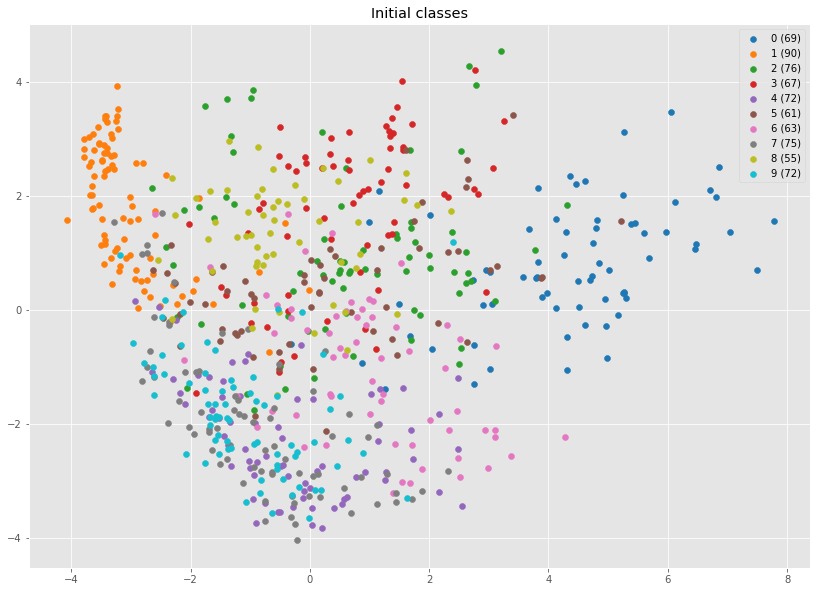

In [4]:
colors = mcolors.TABLEAU_COLORS
labels = range(0, 10)

plt.figure(figsize=(14, 10))
plt.title('Initial classes')

for label, color in zip(labels, colors):
    rows_to_draw = principal_df[2] == label
    plt.scatter(principal_df.loc[rows_to_draw, 0],
                principal_df.loc[rows_to_draw, 1],
                c=color,
                label=f'{label} ({rows_to_draw.sum()})')

plt.legend()
plt.show()

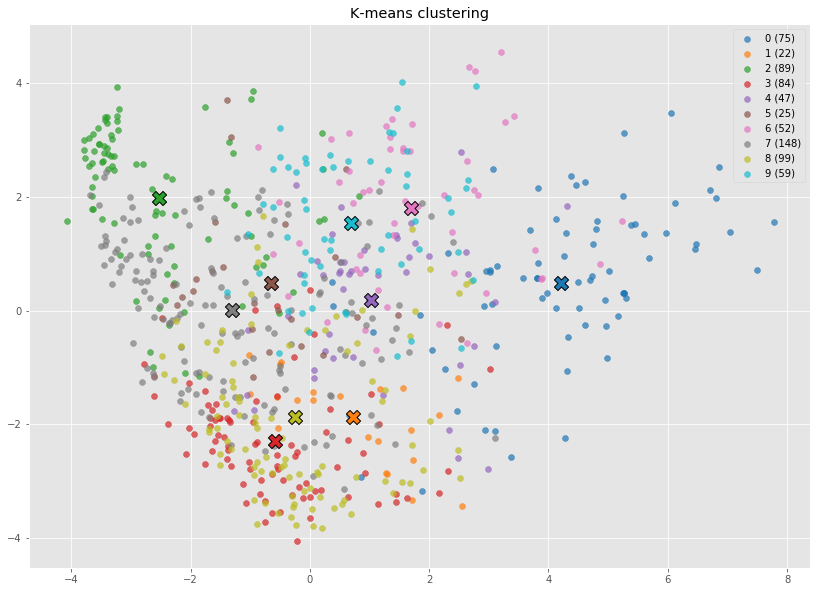

In [5]:
k_means = KMeansClustering(k=10, max_iterations=500)
k_means.fit(X)

centroids = pca.transform(list(k_means.centroids.values()))

plt.figure(figsize=(14, 10))
plt.title('K-means clustering')

for (cluster, data), color in zip(k_means.classes.items(), colors):
    data = pca.transform(data)
    data = list(map(list, zip(*data)))
    plt.scatter(data[0], data[1], c=color, label=f'{cluster} ({len(data[0])})', alpha=0.7)

for color, centroid in zip(colors, centroids):
    plt.scatter(centroid[0], centroid[1], c=color, marker='X', edgecolors='k', linewidth='1', s=200)

plt.legend()
plt.show()

In [6]:
def cluster_rand(classes, clusters):
    tp, tn, fp, fn = 0, 0, 0, 0
    for pair1 in zip(classes, clusters):
        for pair2 in zip(classes, clusters):
            tp += 1 if pair1[0] == pair2[0] and pair1[1] == pair2[1] else 0
            tn += 1 if pair1[0] != pair2[0] and pair1[1] == pair2[1] else 0
            fp += 1 if pair1[0] == pair2[0] and pair1[1] != pair2[1] else 0
            fn += 1 if pair1[0] != pair2[0] and pair1[1] != pair2[1] else 0
    return (tp + fn) / (tp + tn + fp + fn)

In [7]:
def cluster_wss(clusters, centroids):
    s = 0
    for cluster, centroid in zip(clusters.values(), centroids.values()):
        for point in cluster:
            s += distance.euclidean(point, centroid)
    return s

In [8]:
def match_clusters_with_classes(classes, clusters):
    X_pred = []
    Y_pred = []
    for cluster, data in clusters.items():
        X_pred.extend(data)
        Y_pred.extend([cluster] * len(data))

    new_X_pred = []
    new_Y_pred = []

    for real_pic, real_class in classes:
        for pic, cluster in zip(X_pred, Y_pred):
            if np.array_equal(pic, real_pic):
                new_X_pred.append(pic)
                new_Y_pred.append(cluster)
                break
    
    return new_Y_pred

In [10]:
rand_data = []
wss_data = []

for k in range(1, 21):
    km = KMeansClustering(k=k)
    km.fit(X)
    Y_pred = match_clusters_with_classes(zip(X, Y), km.classes)
    rand = cluster_rand(Y, Y_pred)
    wss = cluster_wss(km.classes, km.centroids)
    rand_data.append(rand)
    wss_data.append(wss)

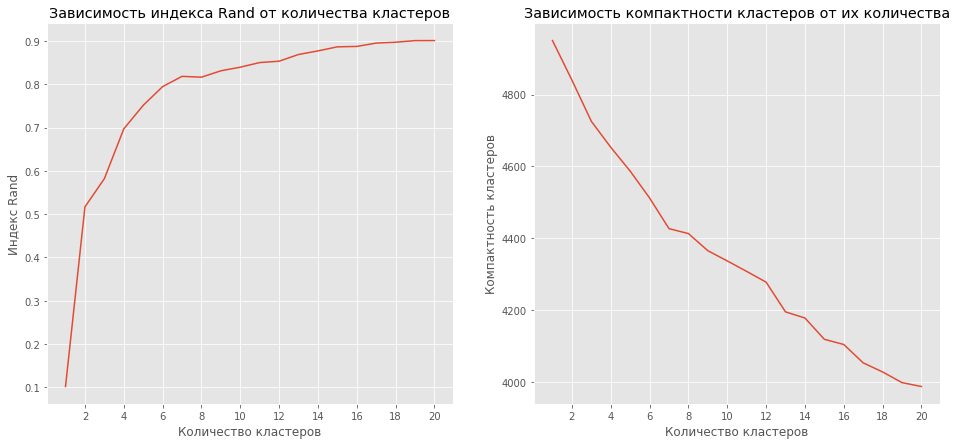

In [25]:
plt.figure(figsize=(16, 7))

plt.subplot(121)
plt.title('Зависимость индекса Rand от количества кластеров')
plt.xticks(range(0, 21, 2))
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс Rand')
plt.plot(range(1, 21), rand_data)

plt.subplot(122)
plt.title('Зависимость компактности кластеров от их количества')
plt.xticks(range(0, 21, 2))
plt.xlabel('Количество кластеров')
plt.ylabel('Компактность кластеров')
plt.plot(range(1, 21), wss_data)

plt.show()